In [61]:
import os
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from Bio.PDB import PDBParser

from catboost import CatBoostRegressor

from tqdm import tqdm

# Parse PDBbind index

In [3]:
data = {
    'pdb': [],
    'resolution': [],
    'year': [],
    'target': [],
    'value': [],
    'unit': [],
    'precision': []
}

with open('PP/index/INDEX_general_PP.2020') as f:
    for line in tqdm(f.readlines()):
        if not line.startswith('#'):
            parts = line.strip().split()
            pdb = parts[0]
            resolution = 0 if parts[1] == 'NMR' else float(parts[1])
            year = int(parts[2])
            
            if '=' in parts[3]:
                sep = '='
            elif '~' in parts[3]:
                sep = '~'
            elif '<' in parts[3]:
                sep = '<'
            elif '>' in parts[3]:
                sep = '>'
            elif '<=' in parts[3]:
                sep = '<='
            elif '=<' in parts[3]:
                sep = '=<'
            elif '>=' in parts[3]:
                sep = '>='
            elif '=>' in parts[3]:
                sep = '=>'
                
            target, value_unit =  parts[3].split(sep)

            values = re.findall(r'\d+', value_unit)
            if len(values) == 1:
                value = float(values[0])
            elif len(values) == 2:
                value = float('.'.join(values))
            
            unit = re.sub(r'[^a-zA-Z]', '', value_unit)
            
            data['pdb'].append(pdb)
            data['resolution'].append(resolution)
            data['year'].append(year)
            data['target'].append(target)
            data['value'].append(value)
            data['unit'].append(unit)
            data['precision'].append(sep)
            
data = pd.DataFrame(data)

100%|████████████████████████████████████| 2858/2858 [00:00<00:00, 93456.00it/s]


In [4]:
data

,pdb,resolution,year,target,value,unit,precision
0,1fc2,2.80,1981,Kd,22.5,nM,=
1,3sgb,1.80,1983,Kd,17.9,pM,=
2,2tgp,1.90,1983,Kd,2.4,uM,=
3,2ptc,1.90,1983,Kd,60.0,fM,=
4,2sni,2.10,1988,Kd,2.0,pM,=
...,...,...,...,...,...,...,...
2847,6bx8,1.98,2019,Ki,0.2,uM,=
2848,6dwf,1.94,2019,Ki,1.3,nM,=
2849,6n9d,2.67,2019,Ki,17.8,pM,=
2850,6mav,2.37,2019,Ki,33.5,pM,=


In [5]:
data['target'].value_counts()

Kd      2618
Ki       171
IC50      63
Name: target, dtype: int64

In [6]:
data['unit'].value_counts()

nM    1567
uM    1049
pM     200
mM      22
fM      14
Name: unit, dtype: int64

In [7]:
data['precision'].value_counts()

=    2751
~      65
<      20
>      16
Name: precision, dtype: int64

In [8]:
len(data[(data['target'] == 'Kd') & (data['precision'].isin(['=', '~']))])

2588

In [9]:
unit2coeff = {
    'mM': 10e-3,
    'uM': 10e-6,
    'nM': 10e-9,
    'pM': 10e-12,
    'fM': 10e-15,
}

data['coefficient'] = data['unit'].map(unit2coeff)
data['logM'] = np.log10(data['value'] * data['coefficient'])

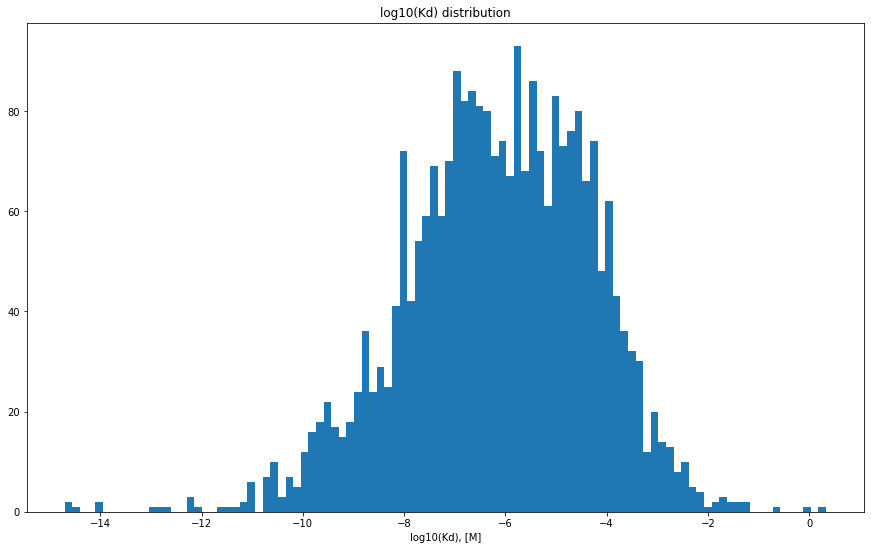

In [10]:
plt.figure(figsize=(15, 9))
plt.hist(data[(data['target'] == 'Kd') & (data['precision'].isin(['=', '~']))]['logM'], bins=100)
plt.title('log10(Kd) distribution')
plt.xlabel('log10(Kd), [M]')

plt.show()

In [11]:
data[data['target']=='Kd']

,pdb,resolution,year,target,value,unit,precision,coefficient,logM
0,1fc2,2.80,1981,Kd,22.50,nM,=,1.000000e-08,-6.647817
1,3sgb,1.80,1983,Kd,17.90,pM,=,1.000000e-11,-9.747147
2,2tgp,1.90,1983,Kd,2.40,uM,=,1.000000e-05,-4.619789
3,2ptc,1.90,1983,Kd,60.00,fM,=,1.000000e-14,-12.221849
4,2sni,2.10,1988,Kd,2.00,pM,=,1.000000e-11,-10.698970
...,...,...,...,...,...,...,...,...,...
2839,6pdx,3.99,2019,Kd,9.74,pM,=,1.000000e-11,-10.011441
2840,6ivz,2.40,2019,Kd,9.70,nM,=,1.000000e-08,-7.013228
2841,6ib8,1.65,2019,Kd,94.00,nM,=,1.000000e-08,-6.026872
2842,6oqj,0.00,2019,Kd,9.00,nM,=,1.000000e-08,-7.045757


# Compute number of chains

In [16]:
# DONE in separate script on cluster

import os
import pickle
import warnings
warnings.filterwarnings('ignore')

from Bio.PDB import PDBParser
from tqdm import tqdm

pdb2chains = {}

pdbs_path = 'work/binding_affinity/pdbbind_protein_protein/pdb_clean_only'
pdbs_path = 'PP'

parser = PDBParser()

for fname in tqdm(os.listdir(pdbs_path)):
    if fname.endswith('ent.pdb'):
        pdb = fname.split('.')[0]
        path = os.path.join(pdbs_path, fname)
        struct = parser.get_structure('s', path)
        pdb2chains[pdb] = ','.join([c.id for c in struct.get_chains()])
        
pickle.dump(pdb2chains, open('pdb2chains.pkl', 'wb'))

100%|███████████████████████████████████████| 2854/2854 [12:40<00:00,  3.75it/s]


In [12]:
import pickle

pdb2chains = pickle.load(open('pdb2chains.pkl', 'rb'))

In [13]:
data['chains'] = data['pdb'].map(pdb2chains)
data['number_of_chains'] = data['chains'].str.split(',').str.len()

In [14]:
data.number_of_chains.value_counts()

2      737
4      613
3      384
6      327
8      173
5      128
12      88
40      85
10      60
20      46
7       28
9       25
16      20
60      15
24      13
30      12
15      12
80       9
18       8
11       7
36       6
21       6
50       4
160      4
13       4
22       3
42       3
32       2
27       2
14       2
120      2
28       2
72       2
17       2
26       1
48       1
23       1
34       1
39       1
1        1
256      1
25       1
102      1
100      1
90       1
38       1
56       1
45       1
19       1
29       1
64       1
33       1
Name: number_of_chains, dtype: int64

In [21]:
data.to_csv('pdbbind_pp_summary.csv', index=False)

In [22]:
len(data)

2852

In [23]:
data[data.pdb == '2mta']

,pdb,resolution,year,target,value,unit,precision,coefficient,logM,chains,number_of_chains
18,2mta,2.4,1994,Kd,4.5,uM,=,0.00001,-4.346787,"H,L,A,C",4


In [78]:
data.isna().any()

pdb                 False
resolution          False
year                False
target              False
value               False
unit                False
precision           False
coefficient         False
logM                False
chains              False
number_of_chains    False
dtype: bool

In [24]:
data[data.number_of_chains > 4]

,pdb,resolution,year,target,value,unit,precision,coefficient,logM,chains,number_of_chains
13,1brs,2.00,1994,Kd,13.00,fM,=,1.000000e-14,-12.886057,"A,B,C,D,E,F",6
25,1mlc,2.50,1995,Kd,91.00,nM,=,1.000000e-08,-6.040959,"A,B,C,D,E,F",6
26,1rlb,3.10,1996,Kd,0.80,uM,=,1.000000e-05,-5.096910,"A,B,C,D,E,F",6
28,1mtn,2.80,1996,Kd,9.50,nM,=,1.000000e-08,-7.022276,"A,B,C,D,E,F,G,H",8
29,1tbr,2.60,1996,Ki,0.20,pM,=,1.000000e-11,-11.698970,"L,H,J,K,R,S",6
...,...,...,...,...,...,...,...,...,...,...,...
2844,6saz,3.00,2019,Ki,0.14,nM,=,1.000000e-08,-8.853872,"A,B,C,D,E,F,G",7
2845,6ht9,3.10,2019,Ki,0.10,nM,=,1.000000e-08,-9.000000,"A,B,C,D,E",5
2846,6dwh,2.00,2019,Ki,0.20,nM,=,1.000000e-08,-8.698970,"A,G,B,C,D,E,F,H,I,J,K,L",12
2847,6bx8,1.98,2019,Ki,0.20,uM,=,1.000000e-05,-5.698970,"A,B,C,D,E,F,G,H",8


In [20]:
parser = PDBParser()

structure_id = "1brs"
filename = "PP/1brs.ent.pdb"
structure = parser.get_structure(structure_id, filename)
structure

<Structure id=1brs>

In [46]:
a = structure.get_residues()
cnt = 0
for el in a:
    cnt += 1
a[el]

(<Residue HOH het=W resseq=129 icode= >, 1101)

In [42]:
model = structure[0]
chain = model['A']
residue = chain[100]
atom = residue["CA"]

In [47]:
cnt = 0
for chain in model:
    cnt += 1
cnt

6

In [49]:
kd_data = data[(data['target'] == 'Kd') & (data['number_of_chains'] == 2)]
len(kd_data)

637

In [71]:
df = []
for i in tqdm(range(len(kd_data))):
    row = kd_data.iloc[i].copy()
    name = row['pdb']
    path = f'PP/{name}.ent.pdb'
    structure = parser.get_structure(structure_id, path)
    cur = []
    for chain in structure[0]:
        cnt = 0
        for residue in chain:
            for atom in residue:
                cnt += 3
        cur.append(cnt)
    df.append(cur)
df = pd.DataFrame(df)
df

100%|█████████████████████████████████████████| 637/637 [01:11<00:00,  8.90it/s]


,0,1
0,4335,1281
1,5202,1494
2,5256,1467
3,6189,1674
4,3603,11352
...,...,...
632,2175,12429
633,1104,1113
634,2340,540
635,5286,1293


In [91]:
df['target'] = list(kd_data['logM'])
df

,0,1,target
0,4335,1281,-9.747147
1,5202,1494,-4.619789
2,5256,1467,-12.221849
3,6189,1674,-10.698970
4,3603,11352,-5.744727
...,...,...,...
632,2175,12429,-6.244125
633,1104,1113,-4.161151
634,2340,540,-7.086186
635,5286,1293,-10.050122


In [95]:
cb = CatBoostRegressor()
sz = len(df) * 3 // 4
cb.fit(df[[0, 1]].iloc[:-sz], df['target'].iloc[:-sz], verbose=False)

In [96]:
pred = cb.predict(df[[0, 1]].iloc[-sz:])

In [97]:
from sklearn.metrics import mean_squared_error as MSE
MSE(df['target'].iloc[-sz:], pred)

4.801064017287472

In [100]:
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 24
plt.rcParams['axes.titlesize'] = 36
plt.rcParams['axes.labelsize'] = 24

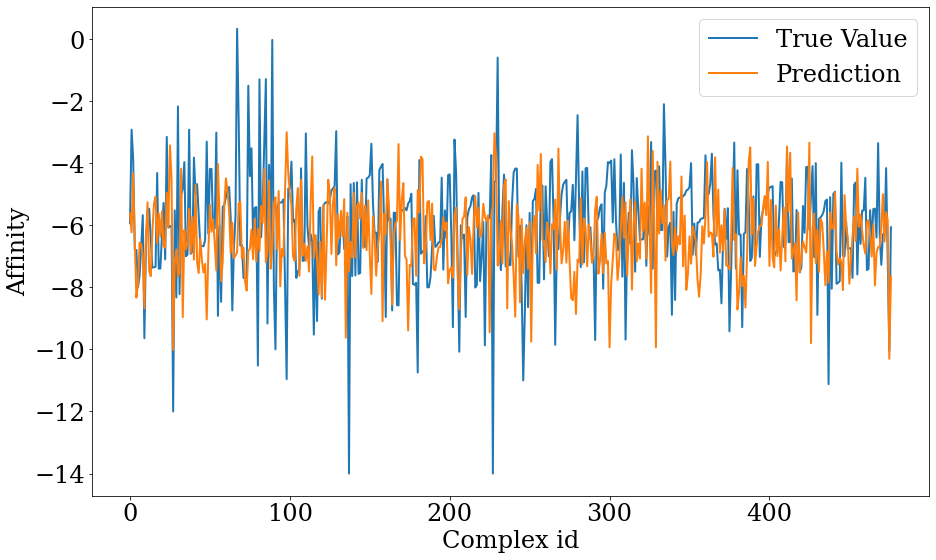

In [111]:
plt.figure(figsize=(15, 9))
grid = np.arange(len(pred))
plt.plot(grid, df['target'].iloc[-sz:], label='True Value')
plt.plot(grid, pred, label='Prediction')
plt.xlabel('Complex id')
plt.ylabel('Affinity')
plt.legend()
plt.savefig('pred.png')
plt.show()

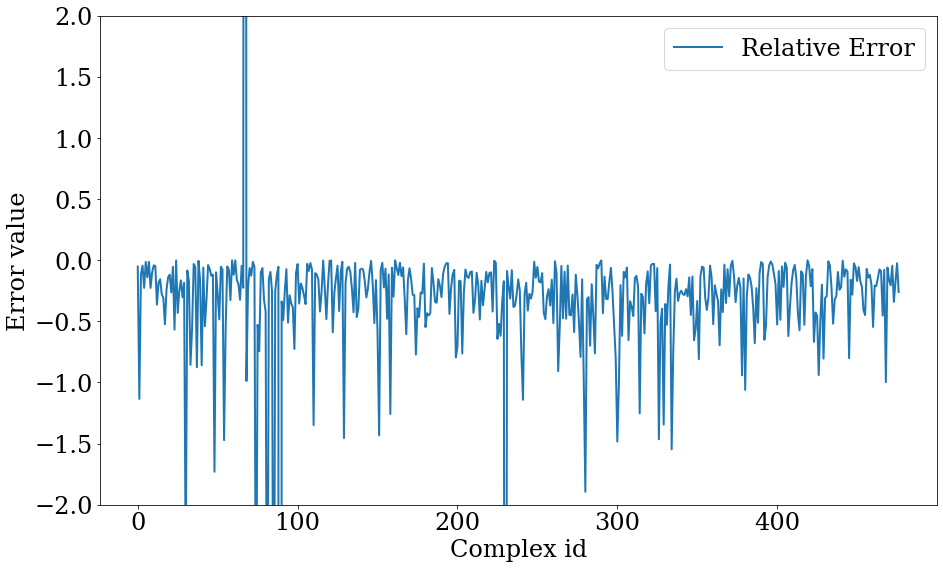

In [110]:
plt.figure(figsize=(15, 9))
err = abs(df['target'].iloc[-sz:] - pred) / df['target'].iloc[-sz:]
grid = np.arange(len(pred))
plt.plot(grid, err, label='Relative Error')
plt.xlabel('Complex id')
plt.ylabel('Error value')
plt.ylim(-2, 2)
plt.legend()
plt.savefig('error.png')
plt.show()

In [113]:
MSE(pred, df['target'].iloc[-sz:])

4.801064017287472

In [122]:
df = df.rename({0: 'first_protein_size', 1: 'second_protein_size'}, axis=1)
df.index = np.arange(1, len(df)+1)
df.to_csv('synthetic.csv')